In [ ]:
import torch
import torch.nn as nn
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}\n")

print("="*50)
print("STEP 1: Loading MLP Classifier")
print("="*50)

checkpoint = torch.load("models/complete_vit.pth", map_location=DEVICE)

num_classes = checkpoint['num_classes']
hidden_size = checkpoint['hidden_size']
class_names = checkpoint['class_names']

print(f"Loaded model info:")
print(f"  - Classes: {class_names}")
print(f"  - Num classes: {num_classes}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - Best MCC: {checkpoint['best_mcc']:.4f}")

class SimpleMLP(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, features):
        return self.fc(features)


mlp_model = SimpleMLP(hidden_size, num_classes).to(DEVICE)
mlp_model.load_state_dict(checkpoint['model_state_dict'])
mlp_model.eval()
print("✓ MLP classifier loaded successfully!\n")


print("="*50)
print("STEP 2: Loading ViT-GPT2 Model")
print("="*50)


print("Loading vit-gpt2-image-captioning model...")
vit_gpt2_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vit_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")


vit_encoder = vit_gpt2_model.encoder.to(DEVICE)
gpt2_decoder = vit_gpt2_model.decoder.to(DEVICE)


vit_encoder.eval()
gpt2_decoder.eval()

print("✓ ViT encoder loaded!")
print("✓ GPT-2 decoder loaded!")
print(f"✓ ViT feature dimension: {vit_encoder.config.hidden_size}")
print("\n" + "="*50)
print("All models loaded successfully!")
print("="*50)
print("\nReady for inference! 🚀")

Using device: cuda

STEP 1: Loading MLP Classifier
Loaded model info:
  - Classes: ['BBMP (garbage)', 'BBMP (pothole)', 'BESCOM', 'BWSSB']
  - Num classes: 4
  - Hidden size: 768
  - Best MCC: 0.9967
✓ MLP classifier loaded successfully!

STEP 2: Loading ViT-GPT2 Model
Loading vit-gpt2-image-captioning model...
✓ ViT encoder loaded!
✓ GPT-2 decoder loaded!
✓ ViT feature dimension: 768

All models loaded successfully!

Ready for inference! 🚀


Image: Img (409).jpg
True Class: BBMP (pothole)
------------------------------------------------------------
Predicted Class: BBMP (pothole)
Confidence: 99.95%
Result: CORRECT ✓
------------------------------------------------------------
 Caption: a road that has a lot of snow on it 


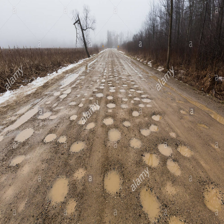

In [ ]:
import os
import random
import torch
from PIL import Image

def predict_image(image_path, mlp_model, vit_encoder, vit_processor, gpt2_decoder, tokenizer, class_names, device):
    """
    Predict class and generate caption for a single image using ViT features
    """
    img = Image.open(image_path).convert('RGB')
    pixel_values = vit_processor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    stored_encoder_output = None  
    def capture_encoder_output(module, input, output):
        nonlocal stored_encoder_output
        stored_encoder_output = output.last_hidden_state
    hook = vit_gpt2_model.encoder.register_forward_hook(capture_encoder_output)  #this stores the features in betwen while running whole pipeline
    with torch.no_grad():
        output_ids = vit_gpt2_model.generate(
            pixel_values,
            max_new_tokens=16,
            num_beams=4,
            early_stopping=True
        )
        caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        cls_features = stored_encoder_output[:, 0, :]
        mlp_model.eval()
        logits = mlp_model(cls_features)
        probs = torch.softmax(logits, dim=1)
        confidence, pred_idx = torch.max(probs, dim=1)
        
        predicted_class = class_names[pred_idx.item()]
        confidence_score = confidence.item()
    hook.remove()
    
    return predicted_class, confidence_score, caption


# -------------------------
# Test on Random Image
# -------------------------
DATASET_PATH = r"C:\Users\tjsre\Desktop\projects\practice\ml\kvsair_dataset\classification\DBMS_classification\dataset"

classes = ['BBMP (garbage)', 'BBMP (pothole)', 'BESCOM', 'BWSSB']
random_class_idx = random.randint(0, len(classes) - 1)
true_class = classes[random_class_idx]

class_folder = os.path.join(DATASET_PATH, true_class)
all_images = os.listdir(class_folder)

random_img_idx = random.randint(0, len(all_images) - 1)
random_image = all_images[random_img_idx]
image_path = os.path.join(class_folder, random_image)



predicted_class, confidence, caption = predict_image(
    image_path, 
    mlp_model, 
    vit_encoder, 
    vit_processor, 
    gpt2_decoder, 
    tokenizer, 
    class_names, 
    DEVICE
)


is_correct = (predicted_class == true_class)


print("="*60)
print(f"Image: {random_image}")
print(f"True Class: {true_class}")
print("-"*60)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Result: {'CORRECT ✓' if is_correct else 'INCORRECT ✗'}")
print("-"*60)
print(f" Caption: {caption}")
print("="*60)

# Optional: Display the image (if using Jupyter)
try:
    from IPython.display import display
    display(Image.open(image_path).resize((224, 224)))
except:
    pass